In [4]:
import networkx as nx
import matplotlib.pyplot as plt

triplets = [
    ("A", "likes", "B"),
    ("B", "likes", "C"),
    ("A", "likes", "C"),
    ("D", "likes", "E"),
    ("E", "likes", "F"),
    ("F", "likes", "G"),
    ("G", "likes", "H"),
]
# Create a knowledge graph
G = nx.DiGraph()
for triplet in triplets:
    G.add_edge(triplet[0], triplet[2], label=triplet[1])

In [24]:
from langchain_community.document_loaders import PyPDFLoader
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings
from langchain_openai import ChatOpenAI
from langchain.chains import create_history_aware_retriever
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain.chains import create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_core.messages import HumanMessage
import os
import ast


os.environ["LANGCHAIN_TRACING_V2"] = "true"
file_path = input("Enter the path to the PDF file: ")
if file_path == '':
    file_path = '/Users/kun/Downloads/a-christmas-carol-charles-dickens.pdf'
# create a vector store
loader = PyPDFLoader(file_path, extract_images=True)
pages = loader.load_and_split()
faiss_index = FAISS.from_documents(pages, OpenAIEmbeddings())
retriever = faiss_index.as_retriever(search_type="similarity", search_kwargs={"k": 10})
llm = ChatOpenAI(model="gpt-4o-mini")


# create a prompt for the contextualize_q_prompt that incorporates a chat history
contextualize_q_system_prompt = """Given a chat history and the latest user question \
which might reference context in the chat history, formulate a standalone question \
which can be understood without the chat history. Do NOT answer the question, \
just reformulate it if needed and otherwise return it as is."""
contextualize_q_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", contextualize_q_system_prompt),
        MessagesPlaceholder(
            "chat_history"
        ),  # this placeholder will store a list of previous messages
        ("human", "{input}"),
    ]
)

# create a retriver that is history aware
history_aware_retriever = create_history_aware_retriever(
    llm, retriever, contextualize_q_prompt
)

# qa system prompt
triplet_extraction_prompt = """

    You are an assistant for question-answering tasks.
    Use the following pieces of retrieved context to answer the question.
    If you don't know the answer, say "The answer is not in the context."
    If you have to answer a question that involves latex code, output it in a plain text format.
    The answer to the questions must be in the form of a list of knowledge graph triplets.
    A triplet is a triple of the form (subject, predicate, object).
    The subject, predicate, and object must all be nodes in the knowledge graph so they must not be too long.
    The predicate must be a relation between the subject and object.
    Answer only with the one and only one list of triplets.
    Format your response as a Python list of tuples, like this:
    [("Subject1", "Predicate1", "Object1"), ("Subject2", "Predicate2", "Object2")]
    Do not include any other text or explanations in your response.
    {context}

"""

triplet_extraction_prompt_full_power = """

    You are an assistant for question-answering tasks.
    Use the following pieces of retrieved context to answer the question.
    When the answer is not in the context, answer anyway with the best answer you can come up with.
    If you have to answer a question that involves latex code, output it in a plain text format.
    The answer to the questions must be in the form of a list of knowledge graph triplets.
    A triplet is a triple of the form (subject, predicate, object).
    The subject, predicate, and object must all be nodes in the knowledge graph so they must not be too long.
    The predicate must be a relation between the subject and object.
    Answer only with the one and only one list of triplets.
    Format your response as a Python list of tuples, like this:
    [("Subject1", "Predicate1", "Object1"), ("Subject2", "Predicate2", "Object2")]
    Do not include any other text or explanations in your response.
    {context}

"""


# qa final prompt
qa_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", triplet_extraction_prompt_full_power),
        MessagesPlaceholder("chat_history"),
        ("human", "{input}"),
    ]
)

# final chain
question_answer_chain = create_stuff_documents_chain(llm, qa_prompt)
rag_chain = create_retrieval_chain(history_aware_retriever, question_answer_chain)


chat_history = []
graph_history = []
while True:

    user_input = input("You: ")
    print(user_input)
    if user_input.lower() == "exit":
        print("Chatbot: Goodbye!")
        break

    ai_msg = rag_chain.invoke({"input": user_input, "chat_history": chat_history})
    chat_history.extend([HumanMessage(content=user_input), ai_msg["answer"]])
    if ai_msg["answer"] != "The answer is not in the context.":
        graph_history.append(ast.literal_eval(ai_msg["answer"]))
    print("Chatbot: ", end="", flush=True)
    print(ai_msg["answer"])


/Users/kun/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/langchain_community/document_loaders/parsers/pdf.py:153: UserWarning: Unknown PDF Filter!
  warnings.warn("Unknown PDF Filter!")


what is the novel about?
Chatbot: [("A Christmas Carol", "is written by", "Charles Dickens"), ("A Christmas Carol", "was first published on", "December 1, 1843"), ("A Christmas Carol", "is a story about", "Ebenezer Scrooge"), ("Ebenezer Scrooge", "is characterized as", "self-centered and materialistic"), ("Ebenezer Scrooge", "undergoes a transformation after", "being visited by ghosts"), ("A Christmas Carol", "teaches", "important life lessons")]
who are the main characters?
Chatbot: [("A Christmas Carol", "features", "Ebenezer Scrooge"), ("A Christmas Carol", "features", "Bob Cratchit"), ("A Christmas Carol", "features", "Tiny Tim"), ("A Christmas Carol", "features", "Jacob Marley"), ("A Christmas Carol", "features", "Ghost of Christmas Present")]
what is the relationship between this characters?
Chatbot: [("Ebenezer Scrooge", "is the employer of", "Bob Cratchit"), ("Bob Cratchit", "is the father of", "Tiny Tim"), ("Jacob Marley", "is the former partner of", "Ebenezer Scrooge"), ("Gho

In [25]:
graph_history

[[('A Christmas Carol', 'is written by', 'Charles Dickens'),
  ('A Christmas Carol', 'was first published on', 'December 1, 1843'),
  ('A Christmas Carol', 'is a story about', 'Ebenezer Scrooge'),
  ('Ebenezer Scrooge',
   'is characterized as',
   'self-centered and materialistic'),
  ('Ebenezer Scrooge',
   'undergoes a transformation after',
   'being visited by ghosts'),
  ('A Christmas Carol', 'teaches', 'important life lessons')],
 [('A Christmas Carol', 'features', 'Ebenezer Scrooge'),
  ('A Christmas Carol', 'features', 'Bob Cratchit'),
  ('A Christmas Carol', 'features', 'Tiny Tim'),
  ('A Christmas Carol', 'features', 'Jacob Marley'),
  ('A Christmas Carol', 'features', 'Ghost of Christmas Present')],
 [('Ebenezer Scrooge', 'is the employer of', 'Bob Cratchit'),
  ('Bob Cratchit', 'is the father of', 'Tiny Tim'),
  ('Jacob Marley', 'is the former partner of', 'Ebenezer Scrooge'),
  ('Ghost of Christmas Present', 'visits', 'Ebenezer Scrooge'),
  ('Tiny Tim', 'is the son of', '

In [ ]:
G = nx.DiGraph()
for triplets in graph_history:
    for triplet in triplets:
        G.add_edge(triplet[0].lower(), triplet[2].lower() , label=triplet[1].lower())
pos = nx.spring_layout(G, seed=42, ) #k is the spring constant/optimal distance between nodes
labels = nx.get_edge_attributes(G, 'label')
plt.figure(figsize=(20, 16))
nx.draw(G, pos, with_labels=True, font_size=15, node_size=1000, node_color='red', edge_color='black', alpha=0.8)
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_size=8, label_pos=0.5, verticalalignment='baseline')
plt.title('Knowledge Graph')
plt.show()

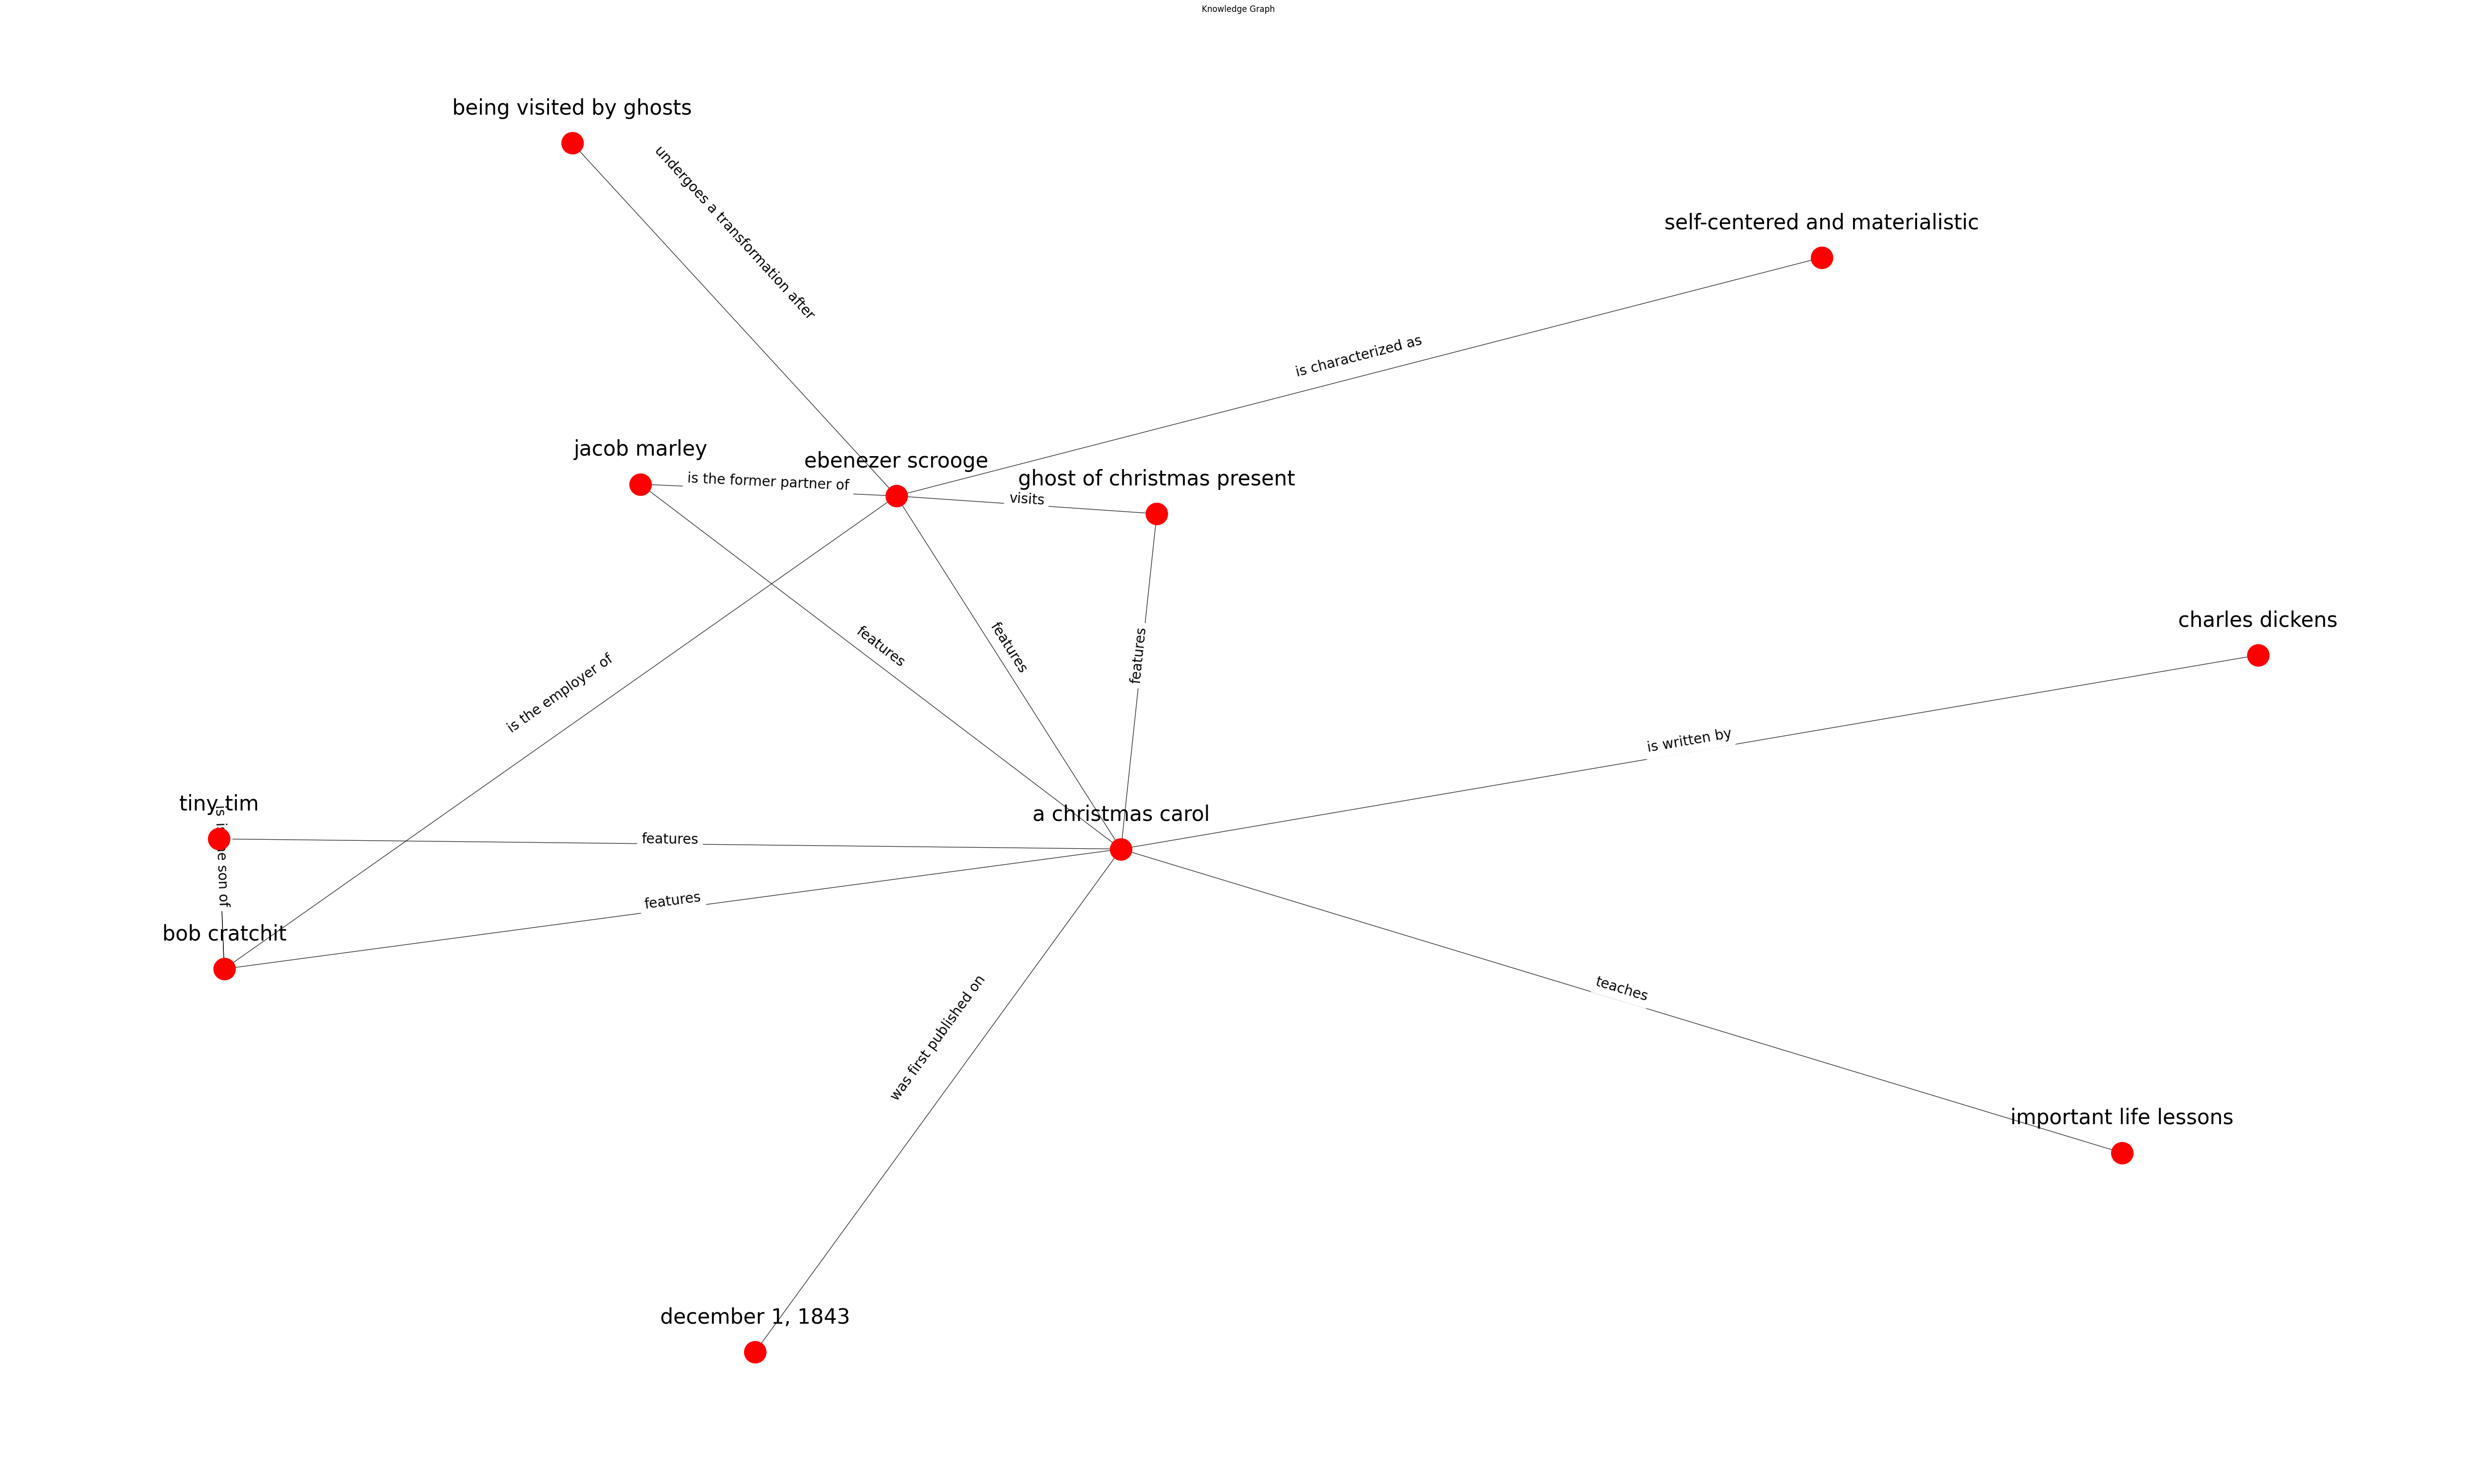

In [31]:
G = nx.DiGraph()
for triplets in graph_history:
    for triplet in triplets:
        G.add_edge(triplet[0].lower(), triplet[2].lower(), label=triplet[1].lower())

pos = nx.spring_layout(G, seed=42, k=0.5)  # Increased k for more spread
labels = nx.get_edge_attributes(G, 'label')
plt.figure(figsize=(50, 30))

# Draw edges
nx.draw_networkx_edges(G, pos, edge_color='black', alpha=0.8)

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_size=1000, node_color='red', alpha=1)

# Draw edge labels
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_size=20, label_pos=0.5, verticalalignment='baseline')

# Draw node labels outside the nodes
for node, (x, y) in pos.items():
    plt.text(x, y+0.05, node, fontsize=30, ha='center', va='center')

plt.title('Knowledge Graph')
plt.axis('off')  # Turn off axis
plt.tight_layout()
plt.show()

In [3]:
# Initialize the LLM
from langchain.schema import HumanMessage, SystemMessage
from langchain_openai import ChatOpenAI

llm_creator = ChatOpenAI(model="gpt-4o-mini")

# Define system and user prompts
system_prompt = """

    You are an assistant for creating a knowledge graph triplets from a given text.
    A triplet is a triple of the form (subject, predicate, object).
    The subject, predicate, and object must all be nodes in the knowledge graph so they must not be too long.
    The predicate must be a relation between the subject and object.
    Answer only with the one and only one list of triplets.
    Format your response as a Python list of tuples, like this:
    [("Subject1", "Predicate1", "Object1"), ("Subject2", "Predicate2", "Object2")]
    Do not include any other text or explanations in your response.
    {text}

"""
user_prompt = """
A Christmas Carol" follows Ebenezer Scrooge, a miser who despises Christmas and is indifferent to the plight of the poor. On Christmas Eve, he is visited by the ghost of his former business partner, Jacob Marley, and the Spirits of Christmas Past, Present, and Yet to Come, who show him the impact of his actions and the importance of compassion and generosity. Ultimately, Scrooge transforms into a kinder, more charitable person, embracing the spirit of Christmas and reconnecting with his family.
"""

# Create message list
messages = [
    SystemMessage(content=system_prompt),
    HumanMessage(content=user_prompt)
]

# Invoke the LLM
response = llm_creator.invoke(messages)

# Print the response
print(response.content)

[("Ebenezer Scrooge", "despises", "Christmas"), ("Ebenezer Scrooge", "is indifferent to", "the plight of the poor"), ("Ebenezer Scrooge", "is visited by", "Jacob Marley"), ("Jacob Marley", "is", "a former business partner"), ("Ebenezer Scrooge", "is visited by", "the Spirits of Christmas"), ("Spirits of Christmas", "show", "the impact of his actions"), ("Scrooge", "transforms into", "a kinder person"), ("Scrooge", "embraces", "the spirit of Christmas"), ("Scrooge", "reconnects with", "his family")]
